In [41]:
from PIL import Image
from skimage import color, filters
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from sklearn.svm import SVC 
from skimage.draw import circle_perimeter
import urllib.request
import os

In [42]:
def crop_image(image, x1, y1, x2, y2):
    cropped_image = image[y1:y2, x1:x2, :]
    return cropped_image

In [43]:
def generate_bouding_boxes(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Convert the image array to L*a*b* color space
    lab_image = color.rgb2lab(image_array)

    # Extract the L, a, and b channels
    L = lab_image[:, :, 0]
    a = lab_image[:, :, 1]
    b = lab_image[:, :, 2]


    # Calculate the RGYB channel
    RGYB = 0.7*L * (1.0*a + 0.7*b)
    YELLOW = 0.7*L * (0.7*a + b)


    # Create a mask for red and green blobs
    red_mask = np.logical_and(RGYB > 2000, L <= 80)
    green_mask = np.logical_and(RGYB < -2000, L <= 80)
    yellow_mask = np.logical_and(YELLOW > 1000, RGYB <= 2000)

    # Apply the masks to the original image
    red_blobs = np.zeros_like(image_array)
    red_blobs[red_mask] = image_array[red_mask]
    green_blobs = np.zeros_like(image_array)
    green_blobs[green_mask] = image_array[green_mask]
    yellow_blobs = np.zeros_like(image_array)
    yellow_blobs[yellow_mask] = image_array[yellow_mask]

    # Convert the red and green blobs to grayscale
    red_gray = color.rgb2gray(red_blobs)
    green_gray = color.rgb2gray(green_blobs)
    yellow_gray = color.rgb2gray(yellow_blobs)

    red_gray = np.where(red_gray > 0, 255, 0).astype(np.uint8)
    green_gray = np.where(green_gray > 0, 255, 0).astype(np.uint8)
    yellow_gray = np.where(yellow_gray > 0, 255, 0).astype(np.uint8)


    # Apply Sobel edge detection
    # red_edges = cv2.Sobel(red_gray, cv2.CV_8U, 1, 1, ksize=5)
    # green_edges = cv2.Sobel(green_gray, cv2.CV_8U, 1, 1, ksize=5)
    # yellow_edges = cv2.Sobel(yellow_gray, cv2.CV_8U, 1, 1, ksize=5)

    # use built-in sobel in Hough Circle Detection
    red_edges = red_gray
    green_edges = green_gray
    yellow_edges = yellow_gray


    # Perform Hough circle detection on red edges
    red_radii = np.arange(5, 30)  # Define the expected radius range for red circles
    red_hough = hough_circle(red_edges, red_radii)
    red_accums, red_centers_x, red_centers_y, red_radii = hough_circle_peaks(red_hough, red_radii, threshold=0.90*np.max(red_hough), min_xdistance = 80, min_ydistance = 80)

    # Perform Hough circle detection on green edges
    green_radii = np.arange(5, 30)  # Define the expected radius range for red circles
    green_hough = hough_circle(green_edges, green_radii)
    green_accums, green_centers_x, green_centers_y, green_radii = hough_circle_peaks(green_hough, green_radii, threshold=0.90*np.max(green_hough), min_xdistance=80, min_ydistance = 80)

    # Perform Hough circle detection on yellow edges
    yellow_radii = np.arange(5, 30)  # Define the expected radius range for yellow circles
    yellow_hough = hough_circle(yellow_edges, yellow_radii)
    yellow_accums, yellow_centers_x, yellow_centers_y, yellow_radii = hough_circle_peaks(yellow_hough, yellow_radii, threshold=0.90*np.max(yellow_hough), min_xdistance=80, min_ydistance = 80)


    # Draw detected circles on the original image

    cropped_images = []
    bounding_boxes = []
    labels = []

    red_circles_image = np.copy(image_array)
    for center_y, center_x, radius in zip(red_centers_y, red_centers_x, red_radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        valid_coords = np.logical_and(circy >= 0, circy < red_circles_image.shape[0]) & np.logical_and(circx >= 0, circx < red_circles_image.shape[1])
        red_circles_image[circy[valid_coords], circx[valid_coords]] = (0, 255, 0)  # Red color for circles
        max_x = red_circles_image.shape[1]
        max_y = red_circles_image.shape[0]
        x1, y1, x2, y2 = max(0,center_x - 1.9*radius), max(0, center_y - 1.9*radius), min(max_x, center_x + 1.9*radius), min(max_y, center_y + (7.0)*radius)
        x1, x2, y1, y2 = round(x1), round(x2), round(y1), round(y2) 
        cropped_images.append(crop_image(image_array, x1, y1, x2, y2))
        bounding_boxes.append([x1, y1, x2, y2])
        labels.append("red")


    green_circles_image = np.copy(image_array)
    for center_y, center_x, radius in zip(green_centers_y, green_centers_x, green_radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        valid_coords = np.logical_and(circy >= 0, circy < green_circles_image.shape[0]) & np.logical_and(circx >= 0, circx < green_circles_image.shape[1])
        green_circles_image[circy[valid_coords], circx[valid_coords]] = (255, 0, 0)  # Green color for circles
        max_x = green_circles_image.shape[1]
        max_y = green_circles_image.shape[0]
        x1, y1, x2, y2 = max(0,center_x - 1.9*radius), max(0, center_y - 7.0*radius), min(max_x, center_x + 1.9*radius), min(max_y, center_y + (1.9)*radius)
        x1, x2, y1, y2 = round(x1), round(x2), round(y1), round(y2) 
        cropped_images.append(crop_image(image_array, x1, y1, x2, y2))
        bounding_boxes.append([x1, y1, x2, y2])
        labels.append("green")
        
    yellow_circles_image = np.copy(image_array)
    for center_y, center_x, radius in zip(yellow_centers_y, yellow_centers_x, yellow_radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        valid_coords = np.logical_and(circy >= 0, circy < yellow_circles_image.shape[0]) & np.logical_and(circx >= 0, circx < yellow_circles_image.shape[1])
        yellow_circles_image[circy[valid_coords], circx[valid_coords]] = (0, 0, 255)  # yellow color for circles
        max_x = yellow_circles_image.shape[1]
        max_y = yellow_circles_image.shape[0]
        x1, y1, x2, y2 = max(0,center_x - 1.9*radius), max(0, center_y - 4.1*radius), min(max_x, center_x + 1.0*radius), min(max_y, center_y + (4.1)*radius)
        x1, x2, y1, y2 = round(x1), round(x2), round(y1), round(y2) 
        cropped_images.append(crop_image(image_array, x1, y1, x2, y2))
        bounding_boxes.append([x1, y1, x2, y2])
        labels.append("yellow")
    
    return bounding_boxes, cropped_images, labels

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bounding_boxes(image_path, annotations):
    # Load the image
    image = plt.imread(image_path)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Iterate over the annotations
    for annotation in annotations:
        x1, y1, x2, y2, class_name, confidence_score = annotation

        # Set bounding box color based on class name
        if class_name == 'red':
            color = 'r'
        elif class_name == 'yellow':
            color = 'y'
        elif class_name == 'green':
            color = 'g'
        else:
            # color = 'w'
            continue

        # Calculate width and height
        width = x2 - x1
        height = y2 - y1

        # Create a rectangle patch
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')

        # Add the patch to the axes
        ax.add_patch(rect)

        # Add class name and confidence score as text
        text = f'{class_name} ({confidence_score:.2f})'
        ax.text(x1, y1, text, fontsize=8, color='white', verticalalignment='top',
                bbox={'facecolor': color, 'alpha': 0.7, 'pad': 0.3})

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Show the plot
    plt.show()


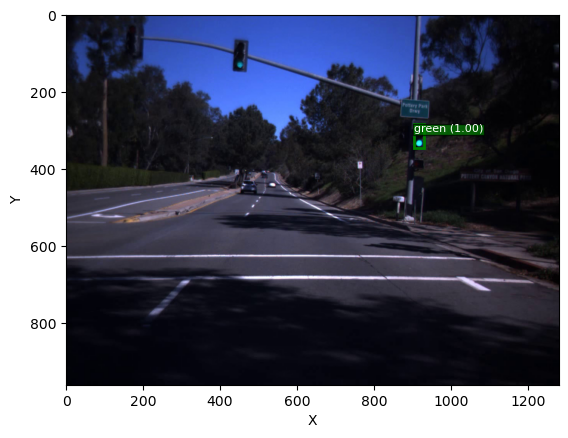

In [46]:
img_path = "15.jpg"
bounding_boxes, cropped_images, lb = generate_bouding_boxes(img_path)
clf = joblib.load("clf.joblib")

X_test = []
img = Image.open(os.path.join(img_path))
for idx, bb in enumerate(bounding_boxes):
    x1, y1, x2, y2 = bb
    cropped_image = img.crop((x1, y1, x2, y2))
    cropped_image = cropped_image.resize((20,34))
    cropped_image = np.array(cropped_image).flatten()  # Flatten the image
    cropped_image = cropped_image.astype(np.float64)/255
    X_test.append(cropped_image)

annotations = []
if len(X_test):
    y_pred = clf.predict(X_test).tolist()
    y_pred_prob = np.max(clf.predict_proba(X_test), axis = 1).tolist()
    annotations = [a + [b, c] for a, b, c in zip((bounding_boxes), (y_pred), (y_pred_prob))]

plot_bounding_boxes(img_path, annotations)